# Analiza ankiety stackoverflow 2020
## Kamil Misiak

W tym sprawozdaniu przeprowadzę analizę zbioru danych zawierające dane z ankiety przeprowadzonej przez portal stackoverflow. Zbiór danych zostanie załadowany, oczyszczony i przeanalizowany.

## Agenda
1. Załadowanie zbioru danych i wstępne statystyki
2. Przygotowanie danych
3. Analiza i wizualizacja danych
4. Pomiar dokładności klasyfikacji
5. Podsumowanie

## Krok 1: Załadowanie zbioru danych i wstępne statystyki

In [1]:
# Przygotowanie danych
import pandas as pd
import numpy as np

# Wizualizacja
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from jupyter_plotly_dash import JupyterDash

import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

# Dostosowanie wyglądu wizualizacji
sns.set_style('darkgrid')
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['figure.facecolor'] = '#00000000'

# Klasyfikacja
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

# Scieżki do plików (dane, schemat)
data_file_name = './data/survey_results_public.csv'
schema_file_name = './data/survey_results_schema.csv'

# Załadowanie zbioru
data_raw = pd.read_csv(data_file_name, sep=',', header=0)

In [2]:
app = JupyterDash('SimpleExample')

app.layout = html.Div([
    dcc.RadioItems(
        id='dropdown-color',
        options=[{'label': c, 'value': c.lower()}
                 for c in ['Red', 'Green', 'Blue']],
        value='red'
    ),
    html.Div(id='output-color'),
    dcc.RadioItems(
        id='dropdown-size',
        options=[{'label': i, 'value': j}
                 for i, j in [('L','large'), ('M','medium'), ('S','small')]],
        value='medium'
    ),
    html.Div(id='output-size')

])

@app.callback(
    dash.dependencies.Output('output-color', 'children'),
    [dash.dependencies.Input('dropdown-color', 'value')])
def callback_color(dropdown_value):
    return "The selected color is %s." % dropdown_value

@app.callback(
    dash.dependencies.Output('output-size', 'children'),
    [dash.dependencies.Input('dropdown-color', 'value'),
     dash.dependencies.Input('dropdown-size', 'value')])
def callback_size(dropdown_color, dropdown_size):
    return "The chosen T-shirt is a %s %s one." %(dropdown_size,
                                                  dropdown_color)

app

#### Następnie przyjrzmy się atrybutom które występują w zbiorze danych

In [3]:
data_raw.columns

Index(['Respondent', 'MainBranch', 'Hobbyist', 'Age', 'Age1stCode', 'CompFreq',
       'CompTotal', 'ConvertedComp', 'Country', 'CurrencyDesc',
       'CurrencySymbol', 'DatabaseDesireNextYear', 'DatabaseWorkedWith',
       'DevType', 'EdLevel', 'Employment', 'Ethnicity', 'Gender', 'JobFactors',
       'JobSat', 'JobSeek', 'LanguageDesireNextYear', 'LanguageWorkedWith',
       'MiscTechDesireNextYear', 'MiscTechWorkedWith',
       'NEWCollabToolsDesireNextYear', 'NEWCollabToolsWorkedWith', 'NEWDevOps',
       'NEWDevOpsImpt', 'NEWEdImpt', 'NEWJobHunt', 'NEWJobHuntResearch',
       'NEWLearn', 'NEWOffTopic', 'NEWOnboardGood', 'NEWOtherComms',
       'NEWOvertime', 'NEWPurchaseResearch', 'NEWPurpleLink', 'NEWSOSites',
       'NEWStuck', 'OpSys', 'OrgSize', 'PlatformDesireNextYear',
       'PlatformWorkedWith', 'PurchaseWhat', 'Sexuality', 'SOAccount',
       'SOComm', 'SOPartFreq', 'SOVisitFreq', 'SurveyEase', 'SurveyLength',
       'Trans', 'UndergradMajor', 'WebframeDesireNextYear',
  

#### Następnie wyświetlimy 5 pierwszych rekordów

In [4]:
data_raw.head()

,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,...,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
0,1,I am a developer by profession,Yes,NaN,13,Monthly,NaN,NaN,Germany,European Euro,...,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",ASP.NET Core,ASP.NET;ASP.NET Core,Just as welcome now as I felt last year,50.0,36,27
1,2,I am a developer by profession,No,NaN,19,NaN,NaN,NaN,United Kingdom,Pound sterling,...,NaN,NaN,NaN,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat more welcome now than last year,NaN,7,4
2,3,I code primarily as a hobby,Yes,NaN,15,NaN,NaN,NaN,Russian Federation,NaN,...,Neither easy nor difficult,Appropriate in length,NaN,NaN,NaN,NaN,Somewhat more welcome now than last year,NaN,4,NaN
3,4,I am a developer by profession,Yes,25.0,18,NaN,NaN,NaN,Albania,Albanian lek,...,NaN,NaN,No,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat less welcome now than last year,40.0,7,4
4,5,"I used to be a developer by profession, but no...",Yes,31.0,16,NaN,NaN,NaN,United States,NaN,...,Easy,Too short,No,"Computer science, computer engineering, or sof...",Django;Ruby on Rails,Ruby on Rails,Just as welcome now as I felt last year,NaN,15,8


#### Oraz końcowe 5 rekordów

In [5]:
data_raw.tail()

,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,...,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
64456,64858,NaN,Yes,NaN,16,NaN,NaN,NaN,United States,NaN,...,NaN,NaN,NaN,"Computer science, computer engineering, or sof...",NaN,NaN,NaN,NaN,10,Less than 1 year
64457,64867,NaN,Yes,NaN,NaN,NaN,NaN,NaN,Morocco,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64458,64898,NaN,Yes,NaN,NaN,NaN,NaN,NaN,Viet Nam,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64459,64925,NaN,Yes,NaN,NaN,NaN,NaN,NaN,Poland,NaN,...,NaN,NaN,NaN,NaN,Angular;Angular.js;React.js,NaN,NaN,NaN,NaN,NaN
64460,65112,NaN,Yes,NaN,NaN,NaN,NaN,NaN,Spain,NaN,...,NaN,NaN,NaN,"Computer science, computer engineering, or sof...",ASP.NET Core;jQuery,Angular;Angular.js;ASP.NET Core;jQuery,NaN,NaN,NaN,NaN


#### Podgląd zbioru

In [6]:
print(data_raw.shape)
print('\n')
print(data_raw.dtypes)

(64461, 61)


Respondent              int64
MainBranch             object
Hobbyist               object
Age                   float64
Age1stCode             object
                       ...   
WebframeWorkedWith     object
WelcomeChange          object
WorkWeekHrs           float64
YearsCode              object
YearsCodePro           object
Length: 61, dtype: object


#### Liczba atrybutów oraz typ danych

In [7]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64461 entries, 0 to 64460
Data columns (total 61 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Respondent                    64461 non-null  int64  
 1   MainBranch                    64162 non-null  object 
 2   Hobbyist                      64416 non-null  object 
 3   Age                           45446 non-null  float64
 4   Age1stCode                    57900 non-null  object 
 5   CompFreq                      40069 non-null  object 
 6   CompTotal                     34826 non-null  float64
 7   ConvertedComp                 34756 non-null  float64
 8   Country                       64072 non-null  object 
 9   CurrencyDesc                  45472 non-null  object 
 10  CurrencySymbol                45472 non-null  object 
 11  DatabaseDesireNextYear        44070 non-null  object 
 12  DatabaseWorkedWith            49537 non-null  object 
 13  D

Jak widać w zbiorze mamy 64461 rekrody, które zawierają 61 atrybutów.
#### Następnie wyświetlimy podstawowe statystki opisowe atrybutów

In [8]:
data_raw.describe()

,Respondent,Age,CompTotal,ConvertedComp,WorkWeekHrs
count,64461.000000,45446.000000,3.482600e+04,3.475600e+04,41151.000000
mean,32554.079738,30.834111,3.190464e+242,1.037561e+05,40.782174
std,18967.442360,9.585392,inf,2.268853e+05,17.816383
min,1.000000,1.000000,0.000000e+00,0.000000e+00,1.000000
25%,16116.000000,24.000000,2.000000e+04,2.464800e+04,40.000000
50%,32231.000000,29.000000,6.300000e+04,5.404900e+04,40.000000
75%,49142.000000,35.000000,1.250000e+05,9.500000e+04,44.000000
max,65639.000000,279.000000,1.111111e+247,2.000000e+06,475.000000


#### Do zbioru danych dodatkowo dołączony jest plik zawierający opisy zawartości atrybutów

In [9]:
schema_raw = pd.read_csv(schema_file_name, index_col='Column')
pd.set_option('display.max_rows', schema_raw.shape[0]+1)
pd.set_option('max_colwidth', None)
schema_raw

,QuestionText
Column,
Respondent,Randomized respondent ID number (not in order of survey response time)
MainBranch,"Which of the following options best describes you today? Here, by ""developer"" we mean ""someone who writes code."""
Hobbyist,Do you code as a hobby?
Age,"What is your age (in years)? If you prefer not to answer, you may leave this question blank."
Age1stCode,"At what age did you write your first line of code or program? (e.g., webpage, Hello World, Scratch project)"
CompFreq,"Is that compensation weekly, monthly, or yearly?"
CompTotal,"What is your current total compensation (salary, bonuses, and perks, before taxes and deductions), in `CurrencySymbol`? Please enter a whole number in the box below, without any punctuation. If you are paid hourly, please estimate an equivalent weekly, monthly, or yearly salary. If you prefer not to answer, please leave the box empty."
ConvertedComp,"Salary converted to annual USD salaries using the exchange rate on 2020-02-19, assuming 12 working months and 50 working weeks."
Country,Where do you live?


Następnie przygotujemy zmienną, dzięki której będziemy mogli odczytywać pytanie należące do danej kolumny.

In [10]:
schema_raw = pd.read_csv(schema_file_name, index_col='Column').QuestionText

In [11]:
# Dowolna nazwa kolumny
schema_raw['WorkWeekHrs']

'On average, how many hours per week do you work? Please enter a whole number in the box.'

## Krok 2: Przygotowanie danych

Chociaż odpowiedzi na ankietę zawierają bogactwo informacji, moja analiza zostanie ograniczona do następujących obszarów:

1. Dane demograficzne respondentów badania
2. Dystrybucja umiejętności programistycznych, doświadczenia i preferencji
3. Informacje, preferencje i opinie dotyczące zatrudnienia

Wybieramy podzbiór kolumn z odpowiednimi danymi do naszej analizy.

In [12]:
selected_columns = [
    # Dane demograficzne
    'Country',
    'Age',
    'Gender',
    'EdLevel',
    'UndergradMajor',
    # Doświadczenie programistyczne
    'Hobbyist',
    'Age1stCode',
    'YearsCode',
    'YearsCodePro',
    'LanguageWorkedWith',
    'LanguageDesireNextYear',
    'NEWLearn',
    'NEWStuck',
    # Zatrudnienie
    'Employment',
    'DevType',
    'WorkWeekHrs',
    'JobSat',
    'JobFactors',
    'NEWOvertime',
    'NEWEdImpt'
]

In [13]:
len(selected_columns)

20

Stworzymy kopię danych z tych kolumn do nowej ramki danych o nazwie "data". Aby kontynuować dalsze przygotowanie danych bez wpływu na orginalny zbiór danych

In [14]:
data = data_raw[selected_columns].copy(deep=True)

In [15]:
schema = schema_raw[selected_columns]

Wyświetlamy podstawowe informacje o ramce danych

In [16]:
data.shape

(64461, 20)

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64461 entries, 0 to 64460
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Country                 64072 non-null  object 
 1   Age                     45446 non-null  float64
 2   Gender                  50557 non-null  object 
 3   EdLevel                 57431 non-null  object 
 4   UndergradMajor          50995 non-null  object 
 5   Hobbyist                64416 non-null  object 
 6   Age1stCode              57900 non-null  object 
 7   YearsCode               57684 non-null  object 
 8   YearsCodePro            46349 non-null  object 
 9   LanguageWorkedWith      57378 non-null  object 
 10  LanguageDesireNextYear  54113 non-null  object 
 11  NEWLearn                56156 non-null  object 
 12  NEWStuck                54983 non-null  object 
 13  Employment              63854 non-null  object 
 14  DevType                 49370 non-null

Następnie określimy pradwidłowe typy dla naszy danych

Zaczniemy od atrybutu "Age1stCode"

In [18]:
schema['Age1stCode']

'At what age did you write your first line of code or program? (e.g., webpage, Hello World, Scratch project)'

Według pytania, atrybut powinnien zawierać wartości liczbowe określające wiek osoby ankietowanej

In [19]:
data['Age1stCode'].unique()

array(['13', '19', '15', '18', '16', '14', '12', '20', '42', '8', '25',
       '22', '30', '17', '21', '10', '46', '9', '7', '11', '6', nan, '31',
       '29', '5', 'Younger than 5 years', '28', '38', '23', '27', '41',
       '24', '53', '26', '35', '32', '40', '33', '36', '54', '48', '56',
       '45', '44', '34', 'Older than 85', '39', '51', '68', '50', '37',
       '47', '43', '52', '85', '64', '55', '58', '49', '76', '72', '73',
       '83', '63'], dtype=object)

Jak widać trafiają się również ciągi znaków np, "Older than 85". Zamiennimy te wartości na puste, ponieważ określają one wartości odstające, które nie są przydatne w anzalizie. Wykonamy tą samą operacje dla 'YearsCode' oraz 'YearsCodePro' ponieważ te atrybuty określają podobne wartości. Poniższe operacje przekstzałcą wartości liczobwe na liczby, a ciągi znaków na wartości puste.

In [20]:
data['Age1stCode'] = pd.to_numeric(data['Age1stCode'], errors='coerce')
data['YearsCode'] = pd.to_numeric(data['YearsCode'], errors='coerce')
data['YearsCodePro'] = pd.to_numeric(data['YearsCodePro'], errors='coerce')

Wyświetlimy podstawe informacje po przekształceniu wartości

In [21]:
data.describe()

,Age,Age1stCode,YearsCode,YearsCodePro,WorkWeekHrs
count,45446.000000,57473.000000,56784.000000,44133.000000,41151.000000
mean,30.834111,15.476572,12.782051,8.869667,40.782174
std,9.585392,5.114081,9.490657,7.759961,17.816383
min,1.000000,5.000000,1.000000,1.000000,1.000000
25%,24.000000,12.000000,6.000000,3.000000,40.000000
50%,29.000000,15.000000,10.000000,6.000000,40.000000
75%,35.000000,18.000000,17.000000,12.000000,44.000000
max,279.000000,85.000000,50.000000,50.000000,475.000000


Wygląda na to, że występuje problem z kolumną wieku, ponieważ minimalna wartość to 1, a maksymalna to 279. Jest to częsty problem z ankietami: odpowiedzi mogą zawierać nieprawidłowe wartości z powodu przypadkowych lub celowych błędów podczas odpowiadania. Prostym rozwiązanie będzie usunięcie wierszy, w których wiek jest wyższy niż 100 lat lub niższy niż 10 lat. Możemy to zrobić za pomocą metody .drop

In [22]:
data.drop(data[data['Age'] < 10].index, inplace=True)
data.drop(data[data['Age'] > 100].index, inplace=True)

To samo dotyczy WorkWeekHrs. Usuniemy wpisy, w których wartość kolumny jest większa niż 140 godzin. (około 20 godzin dziennie).

In [23]:
data.drop(data[data['WorkWeekHrs'] > 140].index, inplace=True)

Kolumna płeć pozwala również na wybranie wielu opcji. Usuniemy wartości zawierające więcej niż jedną opcję, aby uprościć naszą analizę.

In [24]:
data['Gender'].value_counts()

Man                                                            45895
Woman                                                           3835
Non-binary, genderqueer, or gender non-conforming                385
Man;Non-binary, genderqueer, or gender non-conforming            121
Woman;Non-binary, genderqueer, or gender non-conforming           92
Woman;Man                                                         73
Woman;Man;Non-binary, genderqueer, or gender non-conforming       25
Name: Gender, dtype: int64

In [25]:
data.where(~(data['Gender'].str.contains(';', na=False)), np.nan, inplace=True)

Wyczyściliśmy teraz i przygotowaliśmy zbiór danych do analizy. Przyjrzyjmy się próbce wierszy.

In [26]:
data.sample(10)

,Country,Age,Gender,EdLevel,UndergradMajor,Hobbyist,Age1stCode,YearsCode,YearsCodePro,LanguageWorkedWith,LanguageDesireNextYear,NEWLearn,NEWStuck,Employment,DevType,WorkWeekHrs,JobSat,JobFactors,NEWOvertime,NEWEdImpt
9807,Germany,25.0,Man,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Computer science, computer engineering, or software engineering",Yes,18.0,5.0,2.0,Go;Java;JavaScript,Dart;Go;Kotlin;Rust;TypeScript,Once a year,Visit Stack Overflow;Panic;Watch help / tutorial videos,Employed part-time,"Developer, back-end;Developer, mobile;DevOps specialist",20.0,Neither satisfied nor dissatisfied,"Languages, frameworks, and other technologies I’d be working with;Office environment or company culture;Opportunities for professional development",Occasionally: 1-2 days per quarter but less than monthly,Very important
11975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35452,United States,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Employed full-time,NaN,NaN,NaN,NaN,NaN,NaN
56568,Brazil,26.0,Man,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Information systems, information technology, or system administration",No,13.0,9.0,3.0,C#;SQL;TypeScript,C#;C++;HTML/CSS;Java;JavaScript;Python;R;SQL;TypeScript,Once every few years,Meditate;Call a coworker or friend;Visit Stack Overflow,Employed full-time,"Developer, back-end",40.0,Neither satisfied nor dissatisfied,Industry that I’d be working in;How widely used or impactful my work output would be;Office environment or company culture,Sometimes: 1-2 days per month but less than weekly,Fairly important
34899,Sweden,41.0,Man,Some college/university study without earning a degree,"Information systems, information technology, or system administration",Yes,17.0,24.0,15.0,C#;HTML/CSS;JavaScript;SQL;TypeScript;VBA,Bash/Shell/PowerShell;C#;HTML/CSS;JavaScript;SQL,Every few months,Visit Stack Overflow;Go for a walk or other physical activity,Employed full-time,"Developer, desktop or enterprise applications;Developer, front-end;Developer, full-stack;Developer, mobile;Product manager;Senior executive/VP",40.0,Very dissatisfied,Industry that I’d be working in;Flex time or a flexible schedule;Office environment or company culture,Sometimes: 1-2 days per month but less than weekly,Somewhat important
8055,Lithuania,30.0,Man,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Computer science, computer engineering, or software engineering",Yes,24.0,6.0,6.0,HTML/CSS;JavaScript;TypeScript,HTML/CSS;JavaScript;Rust;TypeScript,Once a year,Call a coworker or friend;Visit Stack Overflow;Go for a walk or other physical activity;Watch help / tutorial videos,Employed full-time,"Developer, front-end",40.0,Very satisfied,Flex time or a flexible schedule;How widely used or impactful my work output would be;Opportunities for professional development,Rarely: 1-2 days per year or less,Not at all important/not necessary
30955,India,24.0,Man,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Computer science, computer engineering, or software engineering",Yes,NaN,NaN,NaN,Go;HTML/CSS;JavaScript;Python;TypeScript,Dart;Go;HTML/CSS;JavaScript;Python;R;TypeScript,Once a year,Play games;Visit Stack Overflow;Go for a walk or other physical activity,Employed full-time,"Developer, front-end",NaN,NaN,"Languages, frameworks, and other technologies I’d be working with;Office environment or company culture;Opportunities for professional development",NaN,Somewhat important
55595,Kenya,26.0,Man,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Another engineering discipline (such as civil, electrical, mechanical, etc.)",Yes,25.0,1.0,NaN,Bash/Shell/PowerShell;HTML/CSS;JavaScript;SQL;TypeScript,Bash/Shell/PowerShell;HTML/CSS;JavaScript;SQL;TypeScript,Every few months,Call a coworker or friend;Visit Stack Overflow;Go for a walk or other physical activity;Watch help / tutorial videos;Do other work and come back later,Employed full-time,"Developer, back-end;Developer, front-end;Developer, full-stack;DevOps speciali

## Krok 3: Analiza i wizualizacja danych

W pierwszym kroku przyjrzymy się danym demograficznych respondentów, tj. Kraju, wieku, płci, poziomu wykształcenia, poziomu zatrudnienia itp. Konieczne jest zbadanie tych zmiennych, aby zrozumieć, jak reprezentatywna jest ankieta dla światowej społeczność programistów.

#### Atrybut "Country"

Przyjrzyjmy się liczbie krajów, z których pochodzą odpowiedzi w ankiecie, i wytypujmy dziesięć krajów z największą liczbą odpowiedzi.

In [27]:
schema['Country']

'Where do you live?'

In [28]:
data['Country'].nunique()

183

Kraje o największej liczbie respondentów możemy zidentyfikować metodą value_counts.

In [29]:
top_countries = data['Country'].value_counts().head(10)
top_countries

United States     12371
India              8364
United Kingdom     3881
Germany            3864
Canada             2175
France             1884
Brazil             1804
Netherlands        1332
Poland             1259
Australia          1199
Name: Country, dtype: int64

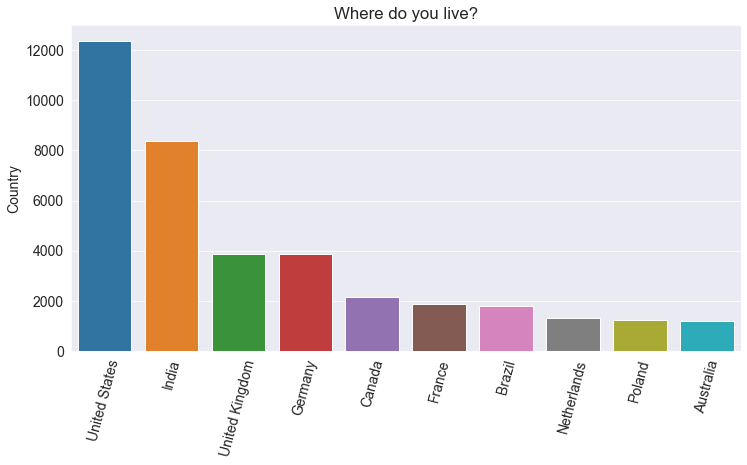

In [30]:
plt.figure(figsize=(12,6))
plt.xticks(rotation=75)
plt.title(schema.Country)

sns.barplot(x=top_countries.index, y=top_countries);

Wygląda na to, że nieproporcjonalnie duża liczba respondentów pochodzi z USA i Indii, prawdopodobnie dlatego, że ankieta jest prowadzona w języku angielskim, a kraje te mają największą populację anglojęzyczną. Można zakładać, że ankieta może nie być reprezentatywna dla globalnej społeczności programistów - zwłaszcza z krajów nieanglojęzycznych.

#### Atrybut "Age"
Rozkład wieku respondentów jest kolejnym czynnikiem, na który warto zwrócić uwagę. Do wizualizacji użyjemy histogramu.

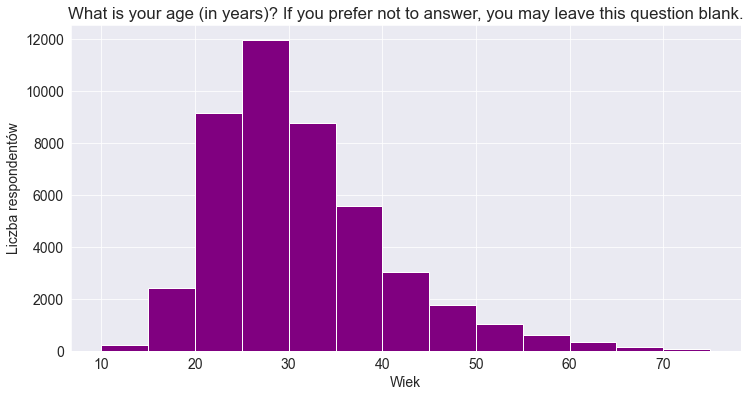

In [31]:
plt.figure(figsize=(12, 6))
plt.title(schema['Age'])
plt.xlabel('Wiek')
plt.ylabel('Liczba respondentów')

plt.hist(data['Age'], bins=np.arange(10,80,5), color='purple');

Wydaje się, że duży odsetek respondentów ma od 20 do 45 lat. Jest to w pewnym stopniu reprezentatywne dla społeczności programistów. Wielu młodych ludzi podjęło się nauki informatyki jako kierunku studiów lub zawodu w ciągu ostatnich 20 lat.

#### Atrybut "Gender"
Przyjrzyjmy się rozkładowi odpowiedzi dla płci. Powszechnie wiadomo, że kobiety są niedostatecznie reprezentowane w społeczności programistów.

In [32]:
schema['Gender']

'Which of the following describe you, if any? Please check all that apply. If you prefer not to answer, you may leave this question blank.'

In [33]:
gender_counts = data['Gender'].value_counts()
gender_counts

Man                                                  45895
Woman                                                 3835
Non-binary, genderqueer, or gender non-conforming      385
Name: Gender, dtype: int64

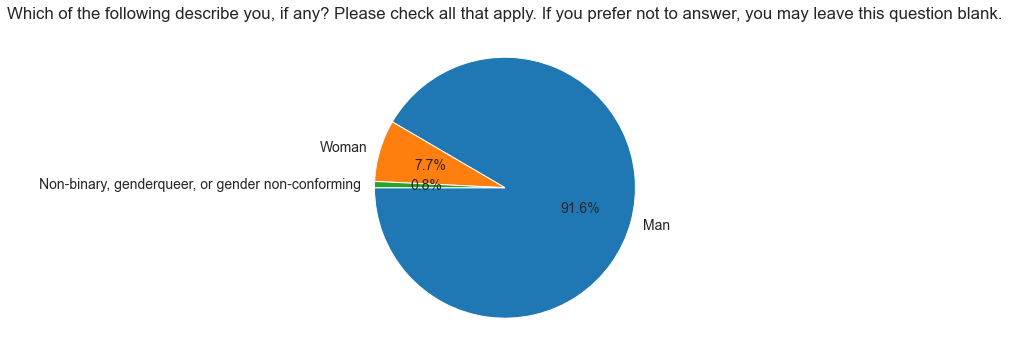

In [34]:
plt.figure(figsize=(12,6))
plt.title(schema.Gender)
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=180);

Tylko około 8% respondentów, którzy odpowiedzieli na pytanie, identyfikuje się jako kobiety lub osoby niebinarne. Liczba ta jest niższa niż ogólny odsetek kobiet i niebinarnych płci w społeczności programistów (szacowany na około 12%).

#### Atrybutu "Education Level"
Formalne wykształcenie informatyczne jest często uważane za niezbędny warunek zostania programistą. Istnieje jednak wiele bezpłatnych kursów i samouczków dostępnych w internecie, aby nauczyć się programowania. Porównajmy poziom wykształcenia respondentów, aby uzyskać wgląd. Użyjemy do tego celu poziomego wykresu słupkowego.

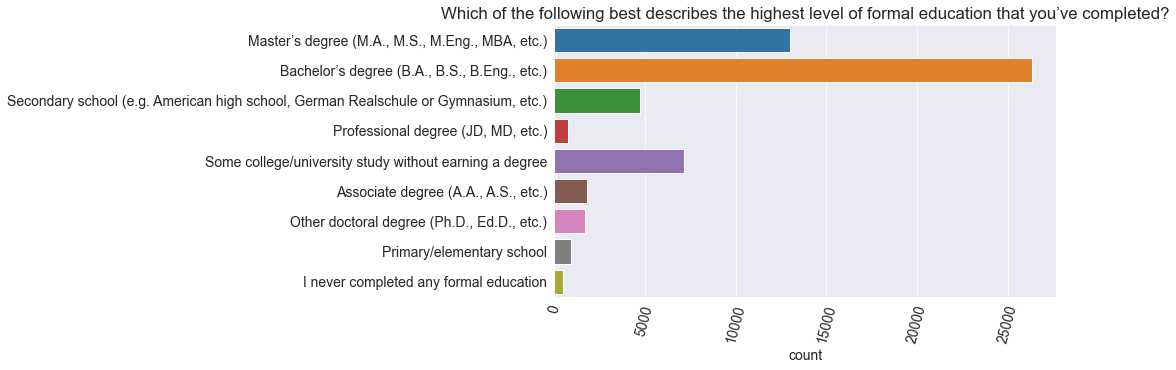

In [35]:
sns.countplot(y=data['EdLevel'])
plt.xticks(rotation=75);
plt.title(schema['EdLevel'])
plt.ylabel(None);

Wydaje się, że ponad połowa respondentów posiada tytuł licencjata lub magistra, więc większość programistów wydaje się mieć wykształcenie wyższe. Jednak z samego tego wykresu nie wynika jasno, czy posiadają dyplom z informatyki.

Następnie przyjrzymy się głównemu kierunkowi nauki, jaki wybrali respondenci.

In [36]:
schema.UndergradMajor

'What was your primary field of study?'

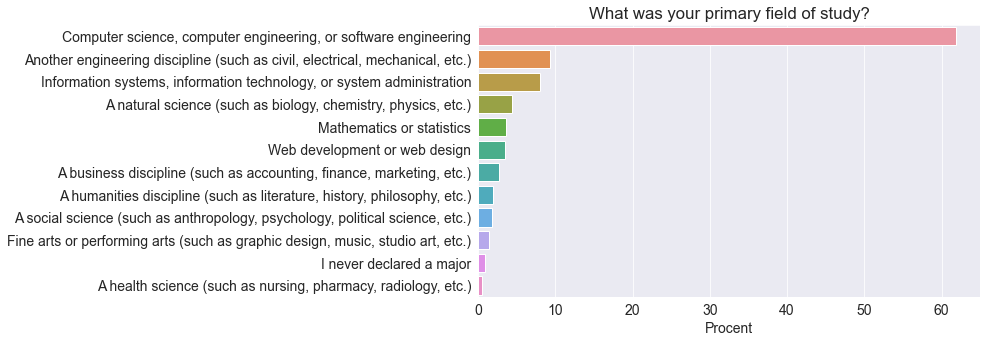

In [37]:
undergrad_pct = data['UndergradMajor'].value_counts() * 100 / data['UndergradMajor'].count()

sns.barplot(x=undergrad_pct, y=undergrad_pct.index)

plt.title(schema['UndergradMajor'])
plt.ylabel(None);
plt.xlabel('Procent');

Okazuje się, że 40% programistów z wyższym wykształceniem ma kierunek inny niż informatyka - co jest bardzo zachęcające. Wydaje się to sugerować, że chociaż wykształcenie wyższe jest ogólnie pomocne, nie musisz studiować informatyki, aby odnieść sukces jako programista.

#### Atrybutu "Employment"
Praca na zlecenie lub własna działalność gospodarcza to częsty wybór wśród programistów, więc byłoby interesujące porównać podział na pracę w pełnym wymiarze godzin, w niepełnym wymiarze godzin i pracę na własny rachunek. Zwizualizujmy dane z kolumny Zatrudnienie.

In [38]:
schema['Employment']

'Which of the following best describes your current employment status?'

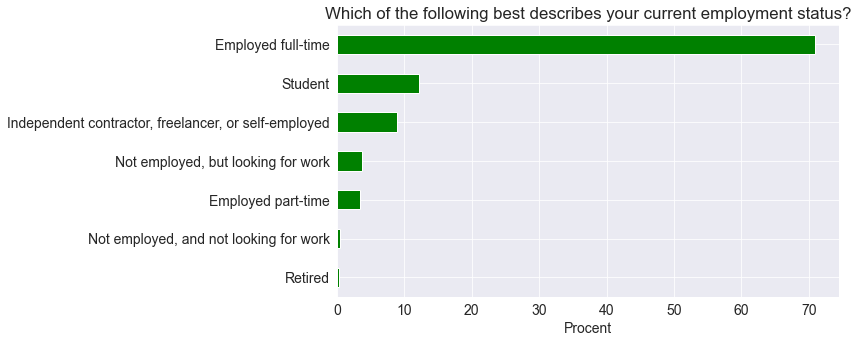

In [39]:
(data['Employment'].value_counts(normalize=True, ascending=True)*100).plot(kind='barh', color='g')
plt.title(schema['Employment'])
plt.xlabel('Procent');

Wygląda na to, że blisko 10% respondentów jest zatrudnionych w niepełnym wymiarze godzin lub jako freelancerzy.

Pole DevType zawiera informacje o rolach pełnionych przez respondentów. Ponieważ pytanie pozwala na wiele odpowiedzi, kolumna zawiera listy wartości oddzielone średnikiem, co utrudnia analizę.

In [40]:
schema['DevType']

'Which of the following describe you? Please select all that apply.'

In [41]:
data['DevType'].value_counts()

Developer, full-stack                                                                                                                                         4396
Developer, back-end                                                                                                                                           3056
Developer, back-end;Developer, front-end;Developer, full-stack                                                                                                2214
Developer, back-end;Developer, full-stack                                                                                                                     1465
Developer, front-end                                                                                                                                          1390
                                                                                                                                                              ... 
Data scientist or mach

Zdefiniujmy funkcję pomocniczą, która zamienia kolumnę zawierającą listy wartości (np. data['DevType']) w ramkę danych z jedną kolumną dla każdej możliwej opcji.

In [42]:
def split_multicolumn(col_series):
    result_df = col_series.to_frame()
    options = []
    # Pętla po wszystkich atrybutach
    for idx, value  in col_series[col_series.notnull()].iteritems():
        # Podział wartośći według średnika
        for option in value.split(';'):
            # Jężeli nie występuje taka wartość, dodanie nowej
            if not option in result_df.columns:
                options.append(option)
                result_df[option] = False
            # Oznaczenie wartośći jak True
            result_df.at[idx, option] = True
    return result_df[options]

In [43]:
dev_type_df = split_multicolumn(data['DevType'])

In [44]:
dev_type_df

,"Developer, desktop or enterprise applications","Developer, full-stack","Developer, mobile",Designer,"Developer, front-end","Developer, back-end","Developer, QA or test",DevOps specialist,"Developer, game or graphics",Database administrator,...,System administrator,Engineering manager,Product manager,Data or business analyst,Academic researcher,Data scientist or machine learning specialist,Scientist,Senior executive/VP,"Engineer, site reliability",Marketing or sales professional
0,True,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64456,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
64457,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
64458,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
64459,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


dev_type_df ma jedną kolumnę dla każdej opcji, którą można wybrać jako odpowiedź. Jeśli respondent wybrał opcję, wtedy kolumna przyjmuje wartość True, W przeciwnym razie wartość False.

Możemy teraz użyć sum według kolumn, aby zidentyfikować najpowszechniejsze role.

In [45]:
dev_type_totals = dev_type_df.sum().sort_values(ascending=False)
dev_type_totals

Developer, back-end                              26996
Developer, full-stack                            26915
Developer, front-end                             18128
Developer, desktop or enterprise applications    11687
Developer, mobile                                 9406
DevOps specialist                                 5915
Database administrator                            5658
Designer                                          5262
System administrator                              5185
Developer, embedded applications or devices       4701
Data or business analyst                          3970
Data scientist or machine learning specialist     3939
Developer, QA or test                             3893
Engineer, data                                    3700
Academic researcher                               3502
Educator                                          2895
Developer, game or graphics                       2751
Engineering manager                               2699
Product ma

#### Najpopularniejszy język programowania w roku 2020?

Aby odpowiedzieć, możemy użyć kolumny LanguageWorkedWith. Podobnie jak w przypadku DevType, respondenci mogli wybrać tutaj wiele opcji.

In [46]:
data['LanguageWorkedWith']

0                                                                                                                                                      C#;HTML/CSS;JavaScript
1                                                                                                                                                            JavaScript;Swift
2                                                                                                                                                    Objective-C;Python;Swift
3                                                                                                                                                                         NaN
4                                                                                                                                                           HTML/CSS;Ruby;SQL
                                                                                         ...                                      

Najpierw podzielimy tę kolumnę na ramkę danych zawierającą kolumnę każdego języka wymienionego w opcjach (tak samo jak w przypadku kolumny "DevType").

In [47]:
languages_worked_df = split_multicolumn(data['LanguageWorkedWith'])

In [48]:
languages_worked_df

,C#,HTML/CSS,JavaScript,Swift,Objective-C,Python,Ruby,SQL,Java,PHP,...,VBA,Perl,Scala,C++,Go,Haskell,Rust,Dart,Julia,Assembly
0,True,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,True,True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,True,False,False,False,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64456,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
64457,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
64458,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
64459,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Wydaje się, że wśród opcji uwzględniono łącznie 25 języków. Zsumujmy je, aby określić procent respondentów, którzy wybrali każdy język.

In [49]:
languages_worked_percentages = languages_worked_df.mean().sort_values(ascending=False) * 100
languages_worked_percentages

JavaScript               59.893323
HTML/CSS                 55.801947
SQL                      48.444935
Python                   39.001026
Java                     35.618760
Bash/Shell/PowerShell    29.239884
C#                       27.803004
PHP                      23.130035
TypeScript               22.461357
C++                      21.114670
C                        19.236152
Go                        7.758219
Kotlin                    6.887382
Ruby                      6.229590
Assembly                  5.447392
VBA                       5.394520
Swift                     5.226573
R                         5.064846
Rust                      4.498803
Objective-C               3.603085
Dart                      3.517557
Scala                     3.150561
Perl                      2.757130
Haskell                   1.861413
Julia                     0.782198
dtype: float64

Możemy zwizualizować te informacje za pomocą poziomego wykresu słupkowego.

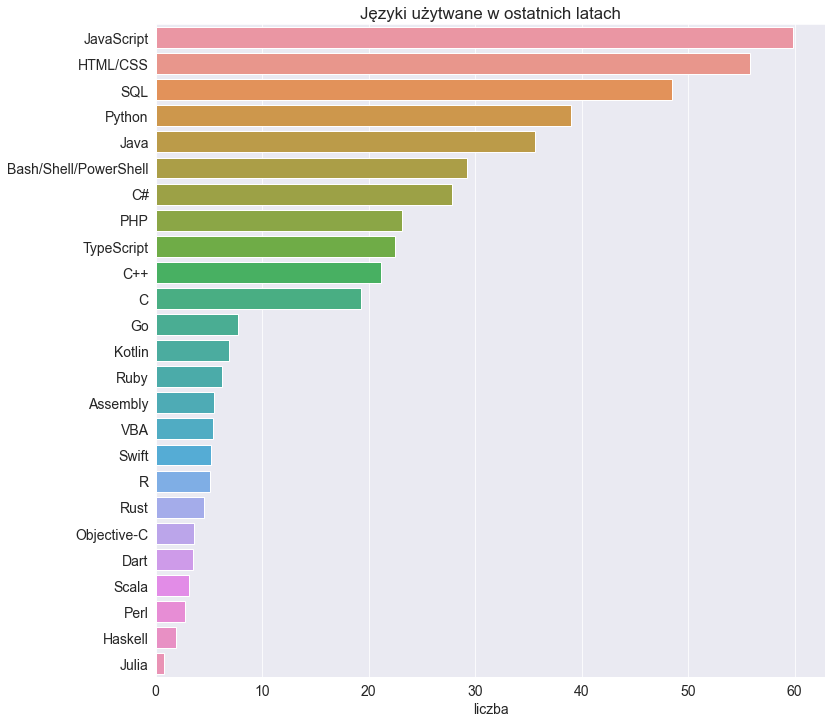

In [50]:
plt.figure(figsize=(12, 12))
sns.barplot(x=languages_worked_percentages, y=languages_worked_percentages.index)
plt.title("Języki użytwane w ostatnich latach");
plt.xlabel('liczba');

Nic dziwnego, że Javascript i HTML / CSS znajdują się na szczycie, ponieważ tworzenie stron internetowych jest obecnie jedną z najbardziej poszukiwanych umiejętności. Jest to również jeden z najłatwiejszych do rozpoczęcia. SQL jest niezbędny do pracy z relacyjnymi bazami danych, nic więc dziwnego, że większość programistów regularnie korzysta z SQL. Wydaje się, że Python jest popularnym wyborem dla innych form programowania, wyprzedzając Javę, która była branżowym standardem w tworzeniu serwerów i aplikacji przez ponad dwie dekady.

#### Jak ważne jest by budować karierę w młodym wieku?

Stwórzmy wykres punktowy przedstawiający zależność Age od YearsCodePro (tj. Wiek i Lata doświadczenia w kodowaniu), aby odpowiedzieć na to pytanie.

In [51]:
schema['YearsCodePro']

'NOT including education, how many years have you coded professionally (as a part of your work)?'

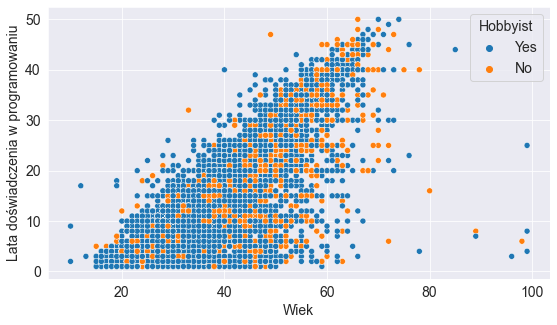

In [52]:
sns.scatterplot(x='Age', y='YearsCodePro', hue='Hobbyist', data=data)
plt.xlabel("Wiek")
plt.ylabel("Lata doświadczenia w programowaniu");

Punkty widoczne są na całym wykresie, co oznacza, że możesz zacząć programować zawodowo w każdym wieku. Wiele osób, które zajmują się programowaniem zawodowo od kilkudziesięciu lat, również lubi to robić jako hobby.

Możemy również zobaczyć rozkład kolumny "Age1stCode", aby zobaczyć, kiedy respondenci próbowali programować po raz pierwszy

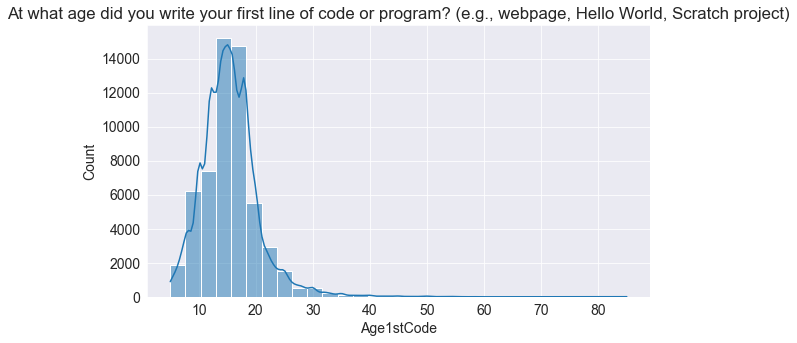

In [53]:
plt.title(schema.Age1stCode)
sns.histplot(x=data['Age1stCode'], bins=30, kde=True);

Jak można się było spodziewać, większość ludzi miała styczność z programowaniem przed czterdziestym rokiem życia. Jednak są ludzie w każdym wieku i ze wszystkich środowisk uczących się kodowania.

## Krok 4: Pomiar dokładności klasyfikacji

W ostatnim kroku spróbujemy sklasyfikować na podstwie pozyskanych danych, z jakiego kraju pochodzi respondent.

Użyjemy do tego zadania atrybutu: Age

In [54]:
selected_columns = [
    'Country',
    'Age'
]

X_data = data[selected_columns].copy(deep=True)
X_data

,Country,Age
0,Germany,NaN
1,United Kingdom,NaN
2,Russian Federation,NaN
3,Albania,25.0
4,United States,31.0
...,...,...
64456,United States,NaN
64457,Morocco,NaN
64458,Viet Nam,NaN
64459,Poland,NaN


Aby uruchomić algorytm klasyfikacji musimy usunąć brakujące wartośći z atrybutu Age. Zrobimy to tym samym sposobem co w sprawozdaniu titanic.

In [55]:
mean = X_data["Age"].mean()
std = X_data["Age"].std()
is_null = X_data["Age"].isnull().sum()

# Losujmey wartości z przedziału wartości średniej i odchylenia standardowego atrybutu "Age"
rand_age = np.random.randint(mean - std, mean + std, size = is_null)

# Uzpełniamy puste wartości w atrybucie "Age" wylosowanymi wartościami
age_slice = X_data["Age"].copy()
age_slice[np.isnan(age_slice)] = rand_age
X_data["Age"] = age_slice
X_data["Age"] = X_data["Age"].astype(int)
X_data["Age"].isnull().sum()

0

In [56]:
X_data = X_data.dropna(axis=0, how='any')

In [57]:
total = X_data.isnull().sum().sort_values(ascending=False)
percent_1 = X_data.isnull().sum()/X_data.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(20)

,Total,%
Age,0,0.0
Country,0,0.0


In [58]:
class ChainedAssignent:
    def __init__(self, chained=None):
        acceptable = [None, 'warn', 'raise']
        assert chained in acceptable, "chained must be in " + str(acceptable)
        self.swcw = chained

    def __enter__(self):
        self.saved_swcw = pd.options.mode.chained_assignment
        pd.options.mode.chained_assignment = self.swcw
        return self

    def __exit__(self, *args):
        pd.options.mode.chained_assignment = self.saved_swcw

Aby ułatwić zadanie algorytmowi klasyfikacji, zostawimy tylko 19 najbardziej popularnych krajów, a reszte zaliczymy do grupy "Other"

In [59]:
freq = X_data['Country'].value_counts()
with ChainedAssignent():
    X_data['Country'][~X_data['Country'].isin(freq.index[:19])] = 'Other'
    X_data['Country'] = X_data['Country'].astype('category')
X_data['Country'].unique()

['Germany', 'United Kingdom', 'Russian Federation', 'Other', 'United States', ..., 'Switzerland', 'Pakistan', 'Romania', 'Turkey', 'Australia']
Length: 20
Categories (20, object): ['Germany', 'United Kingdom', 'Russian Federation', 'Other', ..., 'Pakistan', 'Romania', 'Turkey', 'Australia']

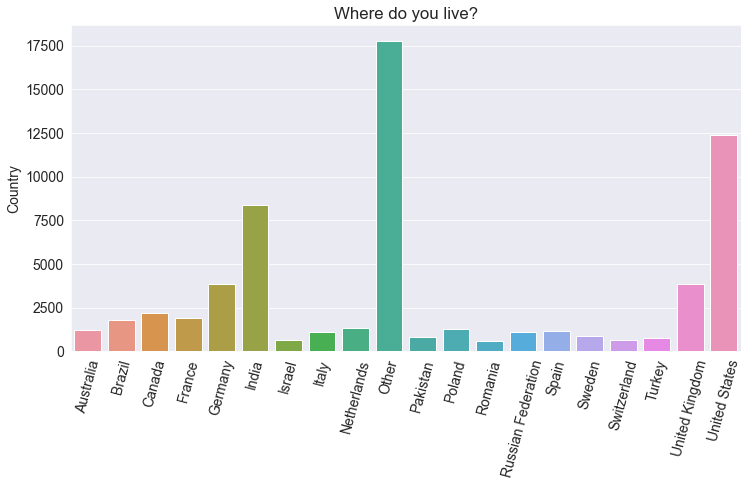

In [60]:
top_countries = X_data['Country'].value_counts().head(20)
top_countries
plt.figure(figsize=(12,6))
plt.xticks(rotation=75)
plt.title(schema.Country)

sns.barplot(x=top_countries.index, y=top_countries);

Jak widać na wykresie, najbardziej popularne grupy to Stany zjednoczone, Indie, i inne

In [61]:
Y_data = X_data['Country'].copy();
X_data = X_data.drop('Country', axis=1)
le = preprocessing.LabelEncoder()
le.fit(Y_data)
Y_data = le.transform(Y_data)

decision_tree = DecisionTreeClassifier()
scores = cross_val_score(decision_tree, X_data, Y_data, cv=10)
scores
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.29 accuracy with a standard deviation of 0.01


Udało się uzyskać dokładność na poziomie około 29%.

## Krok 5: Podsumowanie

Z ankiety pożna wyciągnąć wiele wniosków. Wykonan tutaj analiza stanowi tylko małą część tego czego można się dowiedzieć z analizowanej ankiety. Oto podsumowanie kilku z znalezionych inforamcji:

Na podstawie danych demograficznych respondentów badania możemy wywnioskować, że badanie jest w pewnym stopniu reprezentatywne dla całej społeczności programistów. Jednak ma mniej odpowiedzi od programistów z krajów nieanglojęzycznych oraz kobiet i niebinarnych płci.

Społeczność programistów nie jest tak różnorodna, jak może być. Chociaż sytuacja się poprawia, powinniśmy dołożyć większych starań, aby wspierać i zachęcać niedostatecznie reprezentowane społeczności, czy to pod względem wieku, kraju, rasy, płci, czy w inny sposób.

Chociaż większość programistów ma wyższe wykształcenie, dość duży odsetek nie ma informatyki jako głównego kierunku studiów. Dlatego dyplom z informatyki nie jest obowiązkowy do nauki kodowania lub budowania kariery programistycznej.

Znaczny odsetek programistów pracuje w niepełnym wymiarze godzin lub jako freelancerzy, co może być świetnym sposobem na wejście w tę dziedzinę, zwłaszcza gdy dopiero zaczynasz.

Javascript i HTML / CSS to najczęściej używane języki programowania w 2020 roku, tuż za nimi plasują się SQL i Python.

Wydaje się, że programiści na całym świecie pracują średnio około 40 godzin tygodniowo, z niewielkimi różnicami w zależności od kraju.

Można się uczyć i zacząć programować zawodowo w każdym wieku.